In [1]:
import numpy as np
from numpy.linalg import cholesky
from numpy.linalg import eigvals
from numpy.linalg import inv

import matplotlib.pyplot as pl
%matplotlib inline

# setup plotting
import seaborn as sns
palette = sns.color_palette()
sns.set()

In [2]:
class block_matrix:
    
    # initialize zero matrix
    def __init__(self, n, m, p, q):
        self.matrix = np.zeros((n*p, m*q))
        
    def set_element(self, i, j, a):
        p, q = np.shape(a)
        for k in range(p):
            for l in range(q):
                self.matrix[p*i+k, q*j+l] = a[k, l]
                
    def __str__(self):
        #format_string = '{:.' + str(precision) + 'e}'
        return_string = ''
        format_string = '{:.2e}'
        m, n = np.shape(self.matrix)
        for i in range(m):
            for j in range(n):
                return_string += format_string.format(self.matrix[i, j]) + ' '
            return_string += '\n'
        return return_string

In [3]:
class gp:
    
    def __init__(self, kernel, mean):
        self.kernel = kernel
        self.mean = mean
            
    def _make_covariance_matrix(self, x):
        n = len(x)
        sigma = np.matrix(np.zeros((n, n)))
        for i in range(n):
            for j in range(i+1):
                sigma[i, j] = self.kernel(x[i] - x[j])
                sigma[j, i] = sigma[i, j]
        return sigma
    
    def _make_covariance_matrix_2d(self, x, subcov):
        n = len(x)
        sigma = block_matrix(n, n, 2, 2)
        for i in range(n):
            for j in range(i+1):
                sigma.set_element(i, j, subcov*self.kernel(x[i]-x[j]))
                if i is not j:
                    sigma.set_element(j, i, subcov.T*self.kernel(x[i]-x[j]))
        return sigma.matrix
    
    def sample(self, x, two_d=False, subcov=np.matrix([[1, 1], [1, 1]])):
        if two_d:
            sigma = self._make_covariance_matrix_2d(x, subcov)
            x = np.concatenate((x, x))
            n = len(x)
            L = cholesky(sigma)
            u = np.matrix(np.random.randn(n))
            return np.array(self.mean*np.ones(n) + (L*u.transpose()).transpose())[0]
        else:
            sigma = self._make_covariance_matrix(x)
            n = len(x)
            L = cholesky(sigma)
            u = np.matrix(np.random.randn(n))
            return np.array(self.mean*np.ones(n) + (L*u.transpose()).transpose())[0]
        
class kernel:
    
    def __init__(self):
        return
     
    # apparently with zero white noise the covariance matrix may not be positive definite...    
    def exp_sq_kernel(l, sig, wn=1e-12): 
        def k(r):
            return (sig**2)*np.exp(-(r**2)/(2*(l**2))) + (r == 0)*wn
        return k
               
    def white_noise_kernel(self, white_noise):
        def k(r):
            if r == 0:
                return white_noise
        return k


In [67]:
k = kernel.exp_sq_kernel(1, 1, wn=1e-2)
g = gp(k, 1)

t = np.linspace(0, 100, 500)
c = 11
sig = 10
x = g.sample(t, two_d=True, subcov=np.matrix([[c, sig],[sig, c]]))

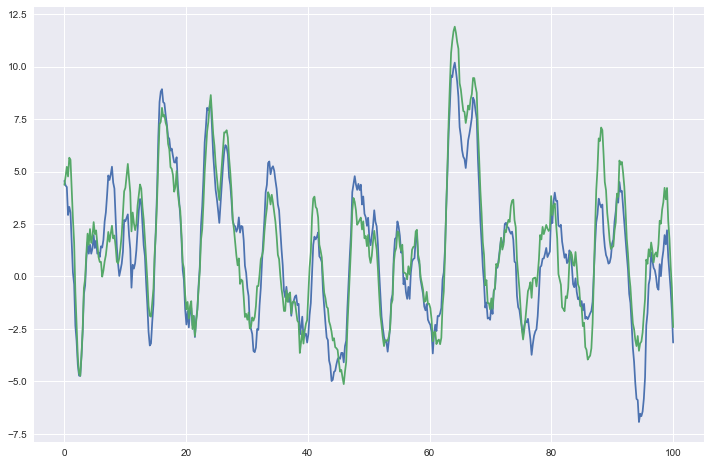

In [68]:
fig = pl.figure(figsize=(12, 8))
x1 = x[::2]
x2 = x[1::2]
pl.plot(t, x2, '-')
pl.plot(t, x1, '-')
#pl.title('just twoooooo correlated gaussian processes', size=20)

In [66]:
a = np.matrix([[5, 3],[3, 5]])
print(eigvals(a))
print()
print(a)

[8. 2.]

[[5 3]
 [3 5]]
